Final Results

* analyzing: Training time, Classification accuracy on validation set, Inference time on validation set

In [1]:
import sys, os
from tqdm.notebook import tqdm
import json
from itertools import product
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, classification_report
)

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import get_data
from src.vit import ViT

device = torch.device(
    'cuda:0' if torch.cuda.is_available()  else \
    'mps' if torch.backends.mps.is_available() else 'cpu'
)

Helpers

In [2]:
def combine_logs(log_dir, ext='.csv', sep='_'):
    dataframes = list()
    for log_file in os.listdir(log_dir):
        if not log_file.endswith(ext): continue

        model_name, dataset_name = log_file.replace(ext, '').split(sep)
        
        df = pd.read_csv(os.path.join(log_dir, log_file))
        # df['Model'] = model_name
        df['Dataset'] = dataset_name
        
        dataframes.append(df)
    return pd.concat(dataframes, axis=0, ignore_index=True)

def summarize_logs(df):
    df = df.groupby(['Dataset', 'Model']).apply(
        lambda x: pd.Series({
            'Avg Training Time (s)' : x['Training Time'].mean().round(2),
            'Avg Inference Time (s)': x['Inference Time'].mean().round(2),
            'Max Accuracy (%)'      : x['Validation Accuracy'].max().round(4)*100
        }
    ), include_groups=False)

    return df.sort_values(['Dataset', 'Max Accuracy (%)'], ascending=[True, False])

def plot_loss(df, loss=True):
    col = 'Loss' if loss else 'Accuracy'

    unq_models = df['Model'].unique()
    unq_datasets = df['Dataset'].unique()

    n_col = 2
    n_row = math.ceil(len(unq_models)*len(unq_datasets) / n_col)

    fig, axes = plt.subplots(n_row, n_col, figsize=(12, 5*n_row))
    flat_axes = axes.flatten()

    for i, (model, dataset) in enumerate(product(unq_models, unq_datasets)):
        mask = (df['Model'] == model) & (df['Dataset'] == dataset)
        
        sns.lineplot(
            data=df[mask], x='Epoch', y=f'Train {col}', ax=flat_axes[i],
            color='blue', label=f'Training {col}'
        )

        sns.lineplot(
            data=df[mask], x='Epoch', y=f'Validation {col}', ax=flat_axes[i],
            color='red', label=f'Validation {col}'
        )

        flat_axes[i].legend(loc='upper right')
        flat_axes[i].set_ylabel(col)
        flat_axes[i].set_title(f'{model} {col.lower()} on {dataset}')
    
    while i+1 < len(flat_axes): flat_axes[i+1].remove(); i += 1
    plt.tight_layout()
    plt.close()

    return fig

def plot_acc(df, loss=True):
    col = 'Loss' if loss else 'Accuracy'

    unq_models = df['Model'].unique()
    unq_datasets = df['Dataset'].unique()

    n_col = 2
    n_row = math.ceil(len(unq_models)*len(unq_datasets) / n_col)

    fig, axes = plt.subplots(n_row, n_col, figsize=(12, 5*n_row))
    flat_axes = axes.flatten()

    for i, (model, dataset) in enumerate(product(unq_models, unq_datasets)):
        mask = (df['Model'] == model) & (df['Dataset'] == dataset)
        
        sns.lineplot(
            data=df[mask], x='Epoch', y=f'Train {col}', ax=flat_axes[i],
            color='blue', label=f'Training {col}'
        )

        sns.lineplot(
            data=df[mask], x='Epoch', y=f'Validation {col}', ax=flat_axes[i],
            color='red', label=f'Validation {col}'
        )

        flat_axes[i].legend(loc='lower right')
        flat_axes[i].set_ylabel(col)
        flat_axes[i].set_title(f'{model} {col.lower()} on {dataset}')
    
    while i+1 < len(flat_axes): flat_axes[i+1].remove(); i += 1
    plt.tight_layout()
    plt.close()

    return fig

def get_model_data(unq_datasets, unq_models, data_dir, checkpoint_dir, my_params, device):
    data = dict()
    for dataset_name in unq_datasets:
        data[dataset_name] = dict()

        dataset_dir = f'{data_dir}/{dataset_name}'
        train_dir = f'{dataset_dir}/train'; test_dir = f'{dataset_dir}/test'

        test_set, channels, image_size, num_classes = get_data(
            dataset_name=dataset_name, train_dir=train_dir, test_dir=test_dir, dwn=True
        )[1:]

        ### MODEL PARAMS ###
        patch_size = my_params[dataset_name].get('patch_size')
        dim = my_params[dataset_name].get('dim')
        dim_head = my_params[dataset_name].get('dim_head')
        mlp_dim = my_params[dataset_name].get('mlp_dim')
        heads = my_params[dataset_name].get('heads')
        depth = my_params[dataset_name].get('depth')
        pool = my_params[dataset_name].get('pool')
        dropout = my_params[dataset_name].get('dropout')
        emb_dropout = my_params[dataset_name].get('emb_dropout')
        la_depth = my_params[dataset_name].get('la_depth')
        la_exp = my_params[dataset_name].get('la_exp')
        ### MODEL PARAMS ###

        ### OTHER PARAMS ###
        batch_size = my_params[dataset_name].get('batch_size')
        ### OTHER PARAMS ###

        data[dataset_name]['valid_loader'] = DataLoader(
            dataset=test_set , batch_size=batch_size, 
            shuffle=False, num_workers=0, pin_memory=True
        )

        for model_name in unq_models:
            model = ViT(
                image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim,
                depth=depth, heads=heads, mlp_dim=mlp_dim, pool=pool, channels=channels,
                dim_head=dim_head, dropout=dropout, emb_dropout=emb_dropout,
                attn_type=model_name, la_depth=la_depth, la_exp=la_exp
            ).to(device)
            
            checkpoint = torch.load(
                f'{checkpoint_dir}/{model_name}_{dataset_name}',
                map_location=device,
                weights_only=True
            )

            model.load_state_dict(checkpoint['model_state_dict'], strict=True)
            model.eval()
            
            data[dataset_name][model_name] = model
    return data

def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = list()
    all_labels = list()
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_cm(unq_models, unq_datasets, model_data):
    n_col = 2
    n_row = math.ceil(len(unq_models)*len(unq_datasets) / n_col)

    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 30))
    flat_axes = axes.flatten()

    for i, (model_name, dataset_name) in enumerate(tqdm(product(unq_models, unq_datasets), leave=False)):
        preds, labels = get_predictions_and_labels(
            model=model_data[dataset_name][model_name],
            dataloader=model_data[dataset_name]['valid_loader'],
            device=device
        )

        cm = confusion_matrix(
            y_true=labels, y_pred=preds, 
            labels=range(len(model_data[dataset_name]['class_names']))
        )

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, 
            display_labels=model_data[dataset_name]['class_names']
        )

        disp.plot(ax=flat_axes[i], cmap='Blues', xticks_rotation='vertical', values_format='d')
        flat_axes[i].set_title(f'{model_name} on {dataset_name}')

    while i+1 < len(flat_axes): flat_axes[i+1].remove(); i += 1
    plt.tight_layout()
    plt.close()
    return fig

Data

In [3]:
data_dir = '../data'

checkpoint_dir = f'{data_dir}/checkpoints'
log_dir = f'{data_dir}/logs'
img_dir = f'{data_dir}/images'

with open(f'{data_dir}/params.json') as f:
    my_params = json.load(f)

Log Tables

In [4]:
combined_df = combine_logs(log_dir=log_dir)
combined_df.head(2)

,Model,Epoch,Training Time,Inference Time,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Dataset
0,relu,0,52.778130,7.511178,1.791116,1.593270,0.332988,0.414844,cifar10
1,relu,1,52.147968,6.581734,1.475303,1.430634,0.458379,0.487598,cifar10


In [5]:
summary_df = summarize_logs(df=combined_df)
summary_df

Avg Training Time (s)  Avg Inference Time (s)  \
Dataset Model                                                    
cifar10 learn                    65.78                    8.17   
        relu                     52.67                    7.09   
        exp                      53.77                    7.21   
        softmax                  52.86                    7.02   
mnist   relu                     14.46                    2.15   
        exp                      14.63                    2.21   
        learn                    15.27                    2.30   
        softmax                  14.69                    2.23   

                 Max Accuracy (%)  
Dataset Model                      
cifar10 learn               79.10  
        relu                79.10  
        exp                 78.77  
        softmax             78.61  
mnist   relu                98.05  
        exp                 97.86  
        learn               97.84  
        softmax             97.34

Log Charts

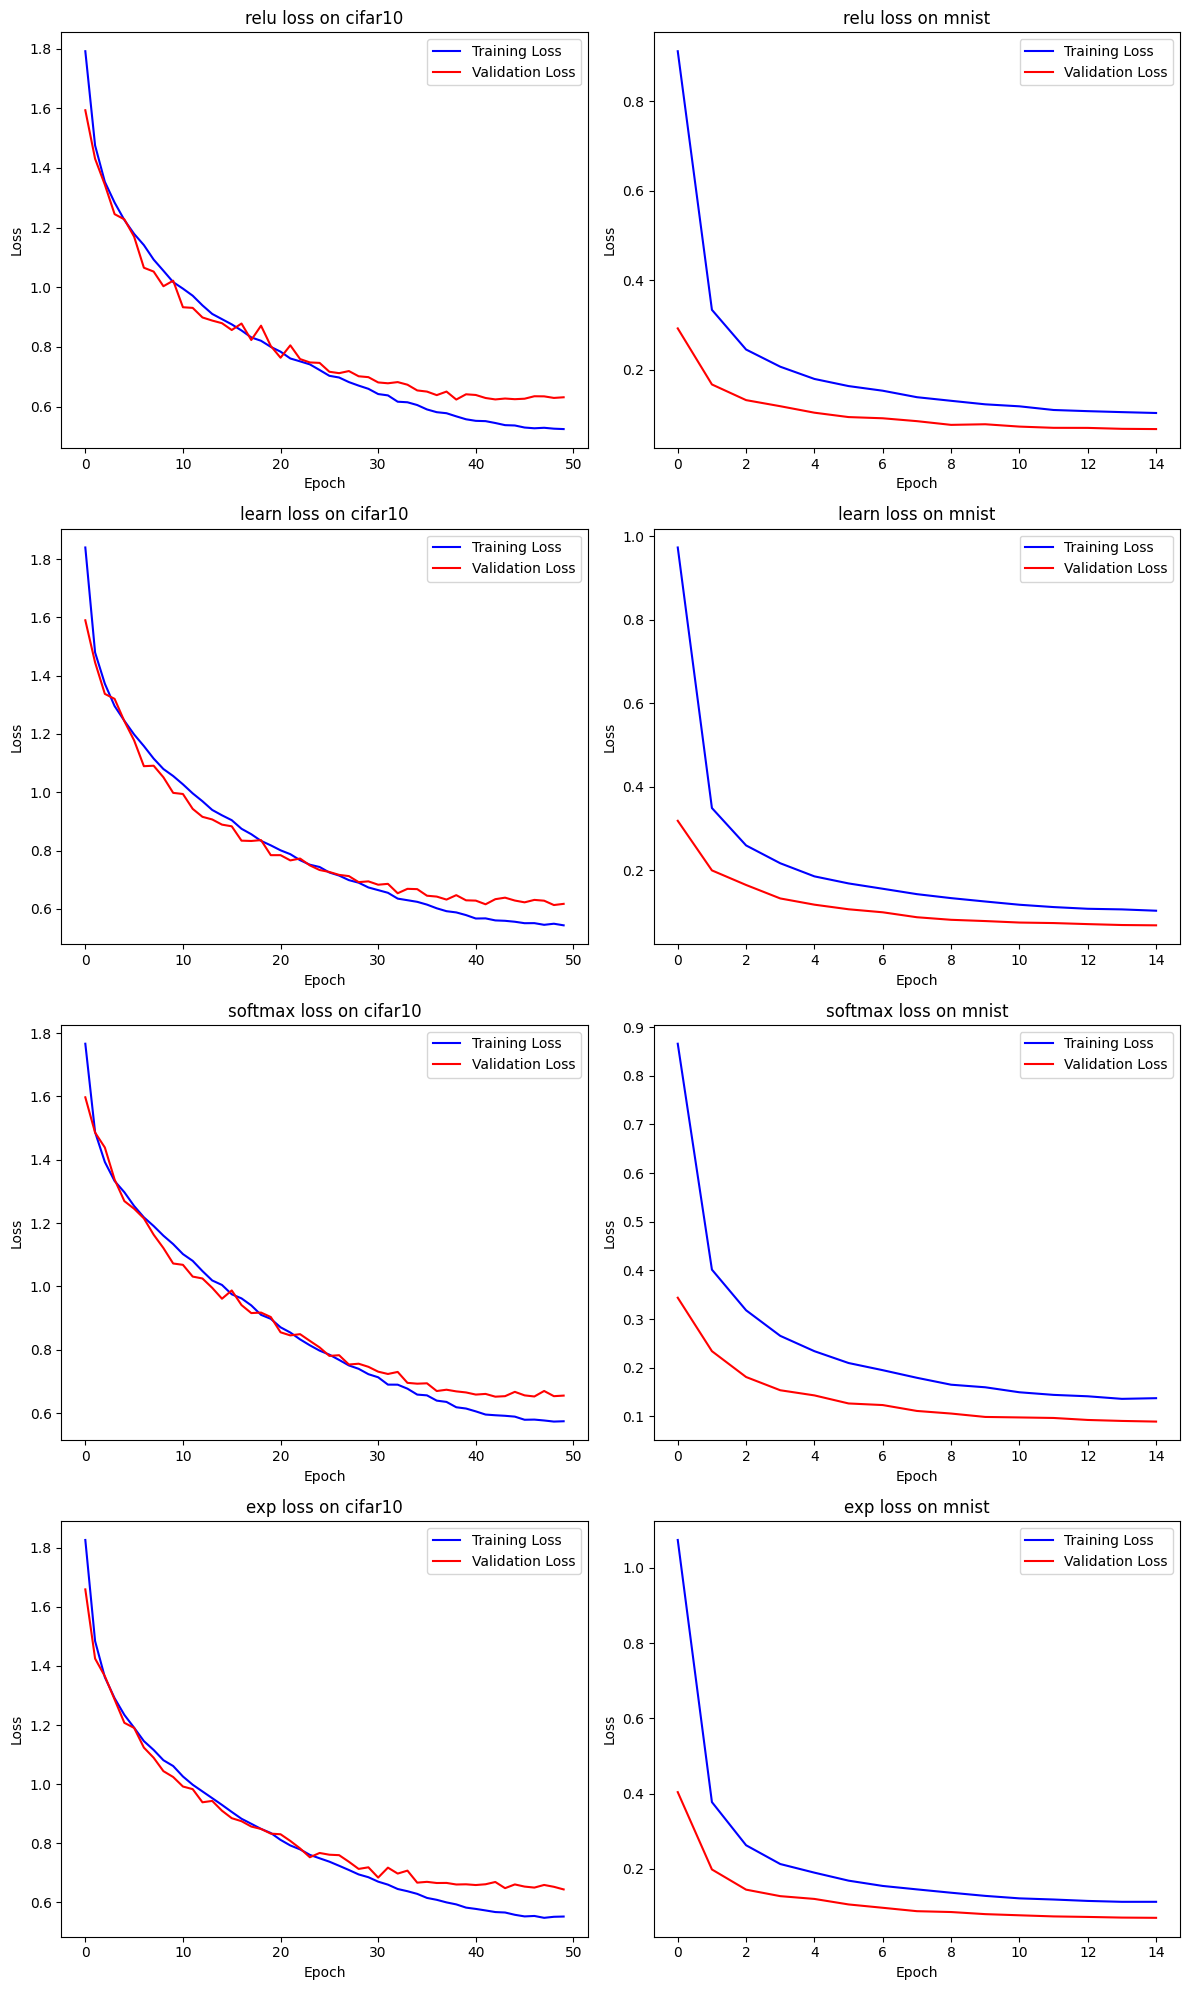

In [6]:
fig = plot_loss(df=combined_df, loss=True)
fig

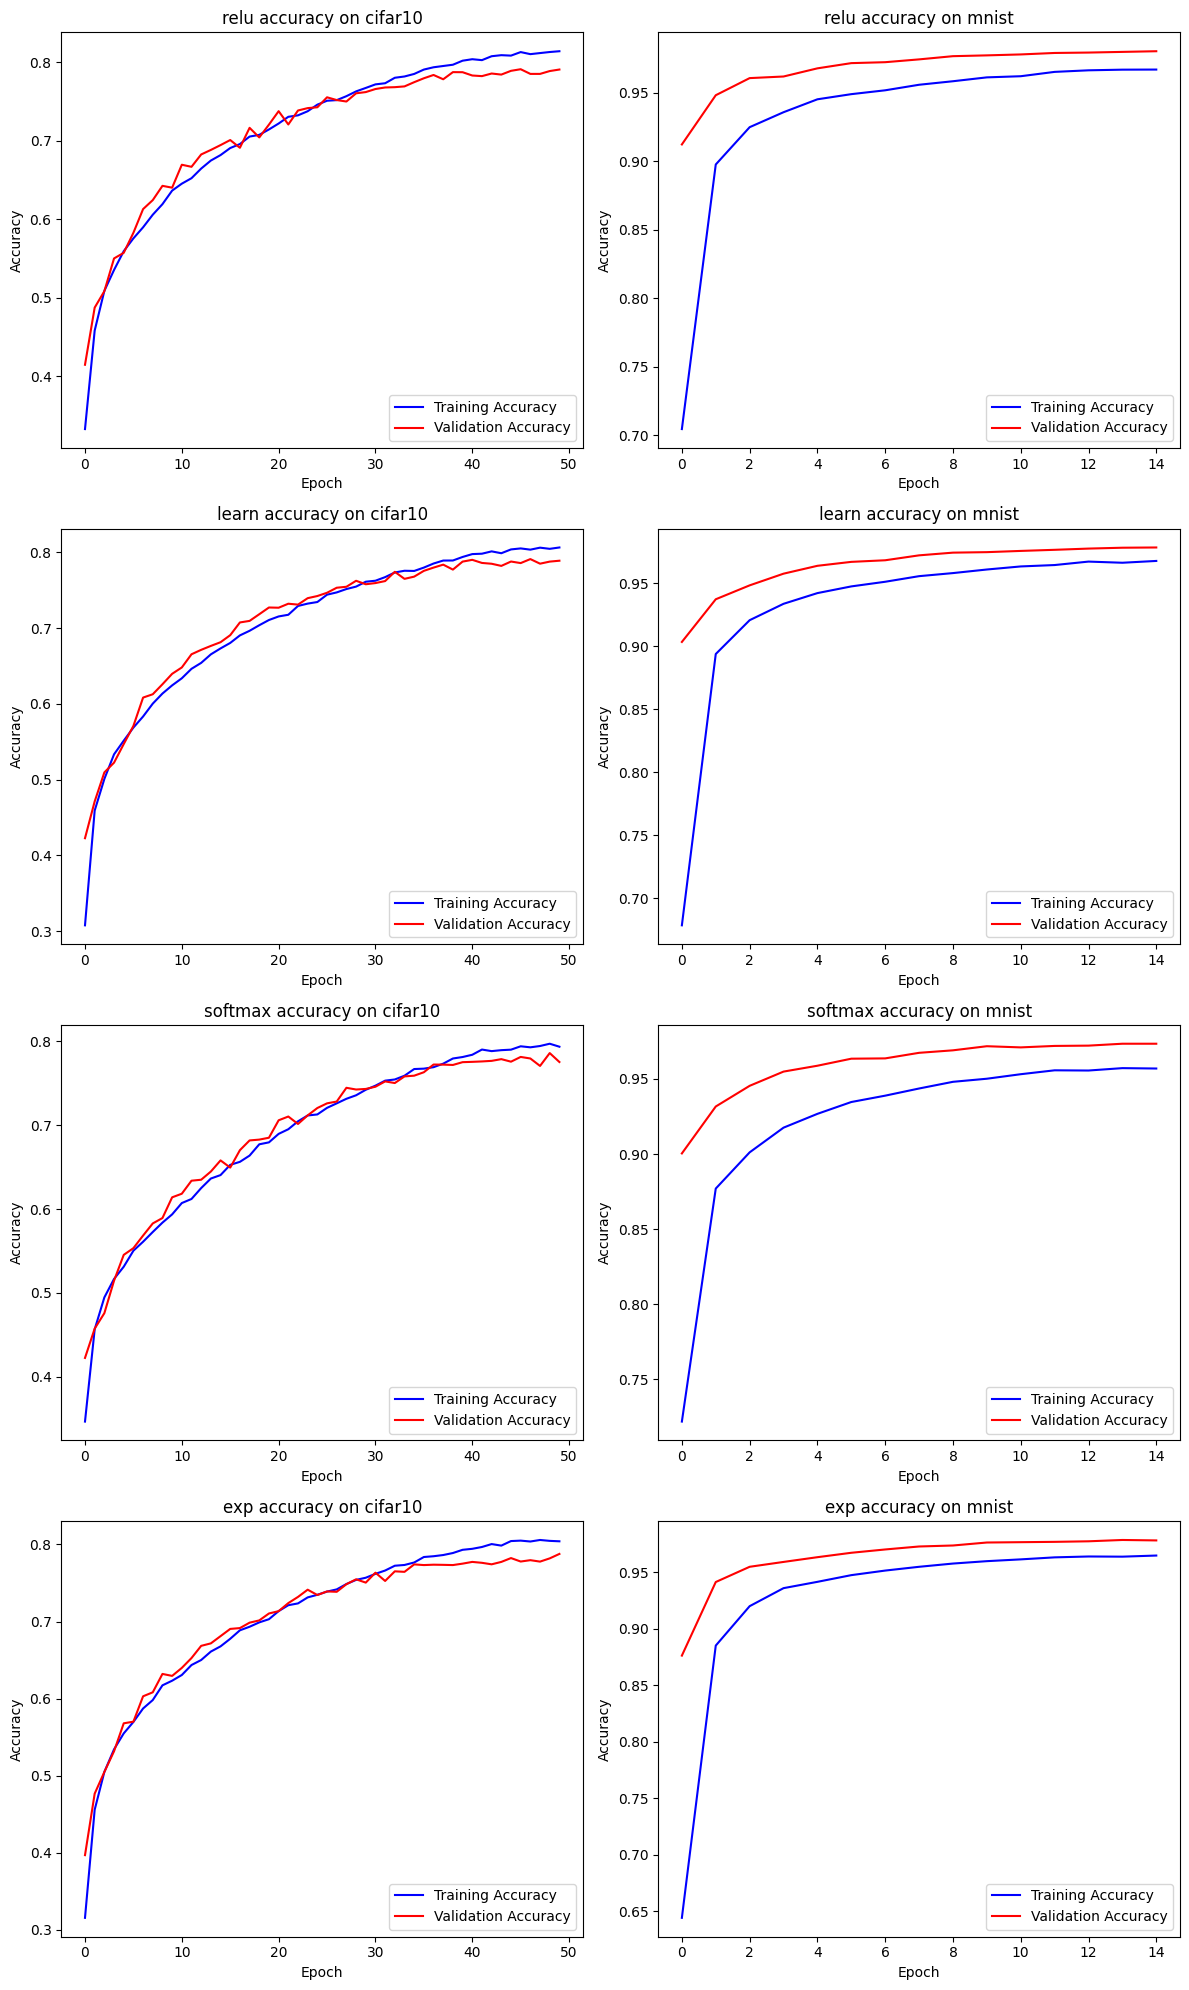

In [7]:
fig = plot_acc(df=combined_df, loss=False)
fig

Analyzing Predictions

In [8]:
unq_models = combined_df['Model'].unique()
unq_datasets = combined_df['Dataset'].unique()

model_data = get_model_data(
    unq_datasets=unq_datasets, unq_models=unq_models, data_dir=data_dir, 
    checkpoint_dir=checkpoint_dir, my_params=my_params, device=device
)

model_data['mnist']['class_names'] = list(range(0, 9+1, 1))

model_data['cifar10']['class_names'] = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

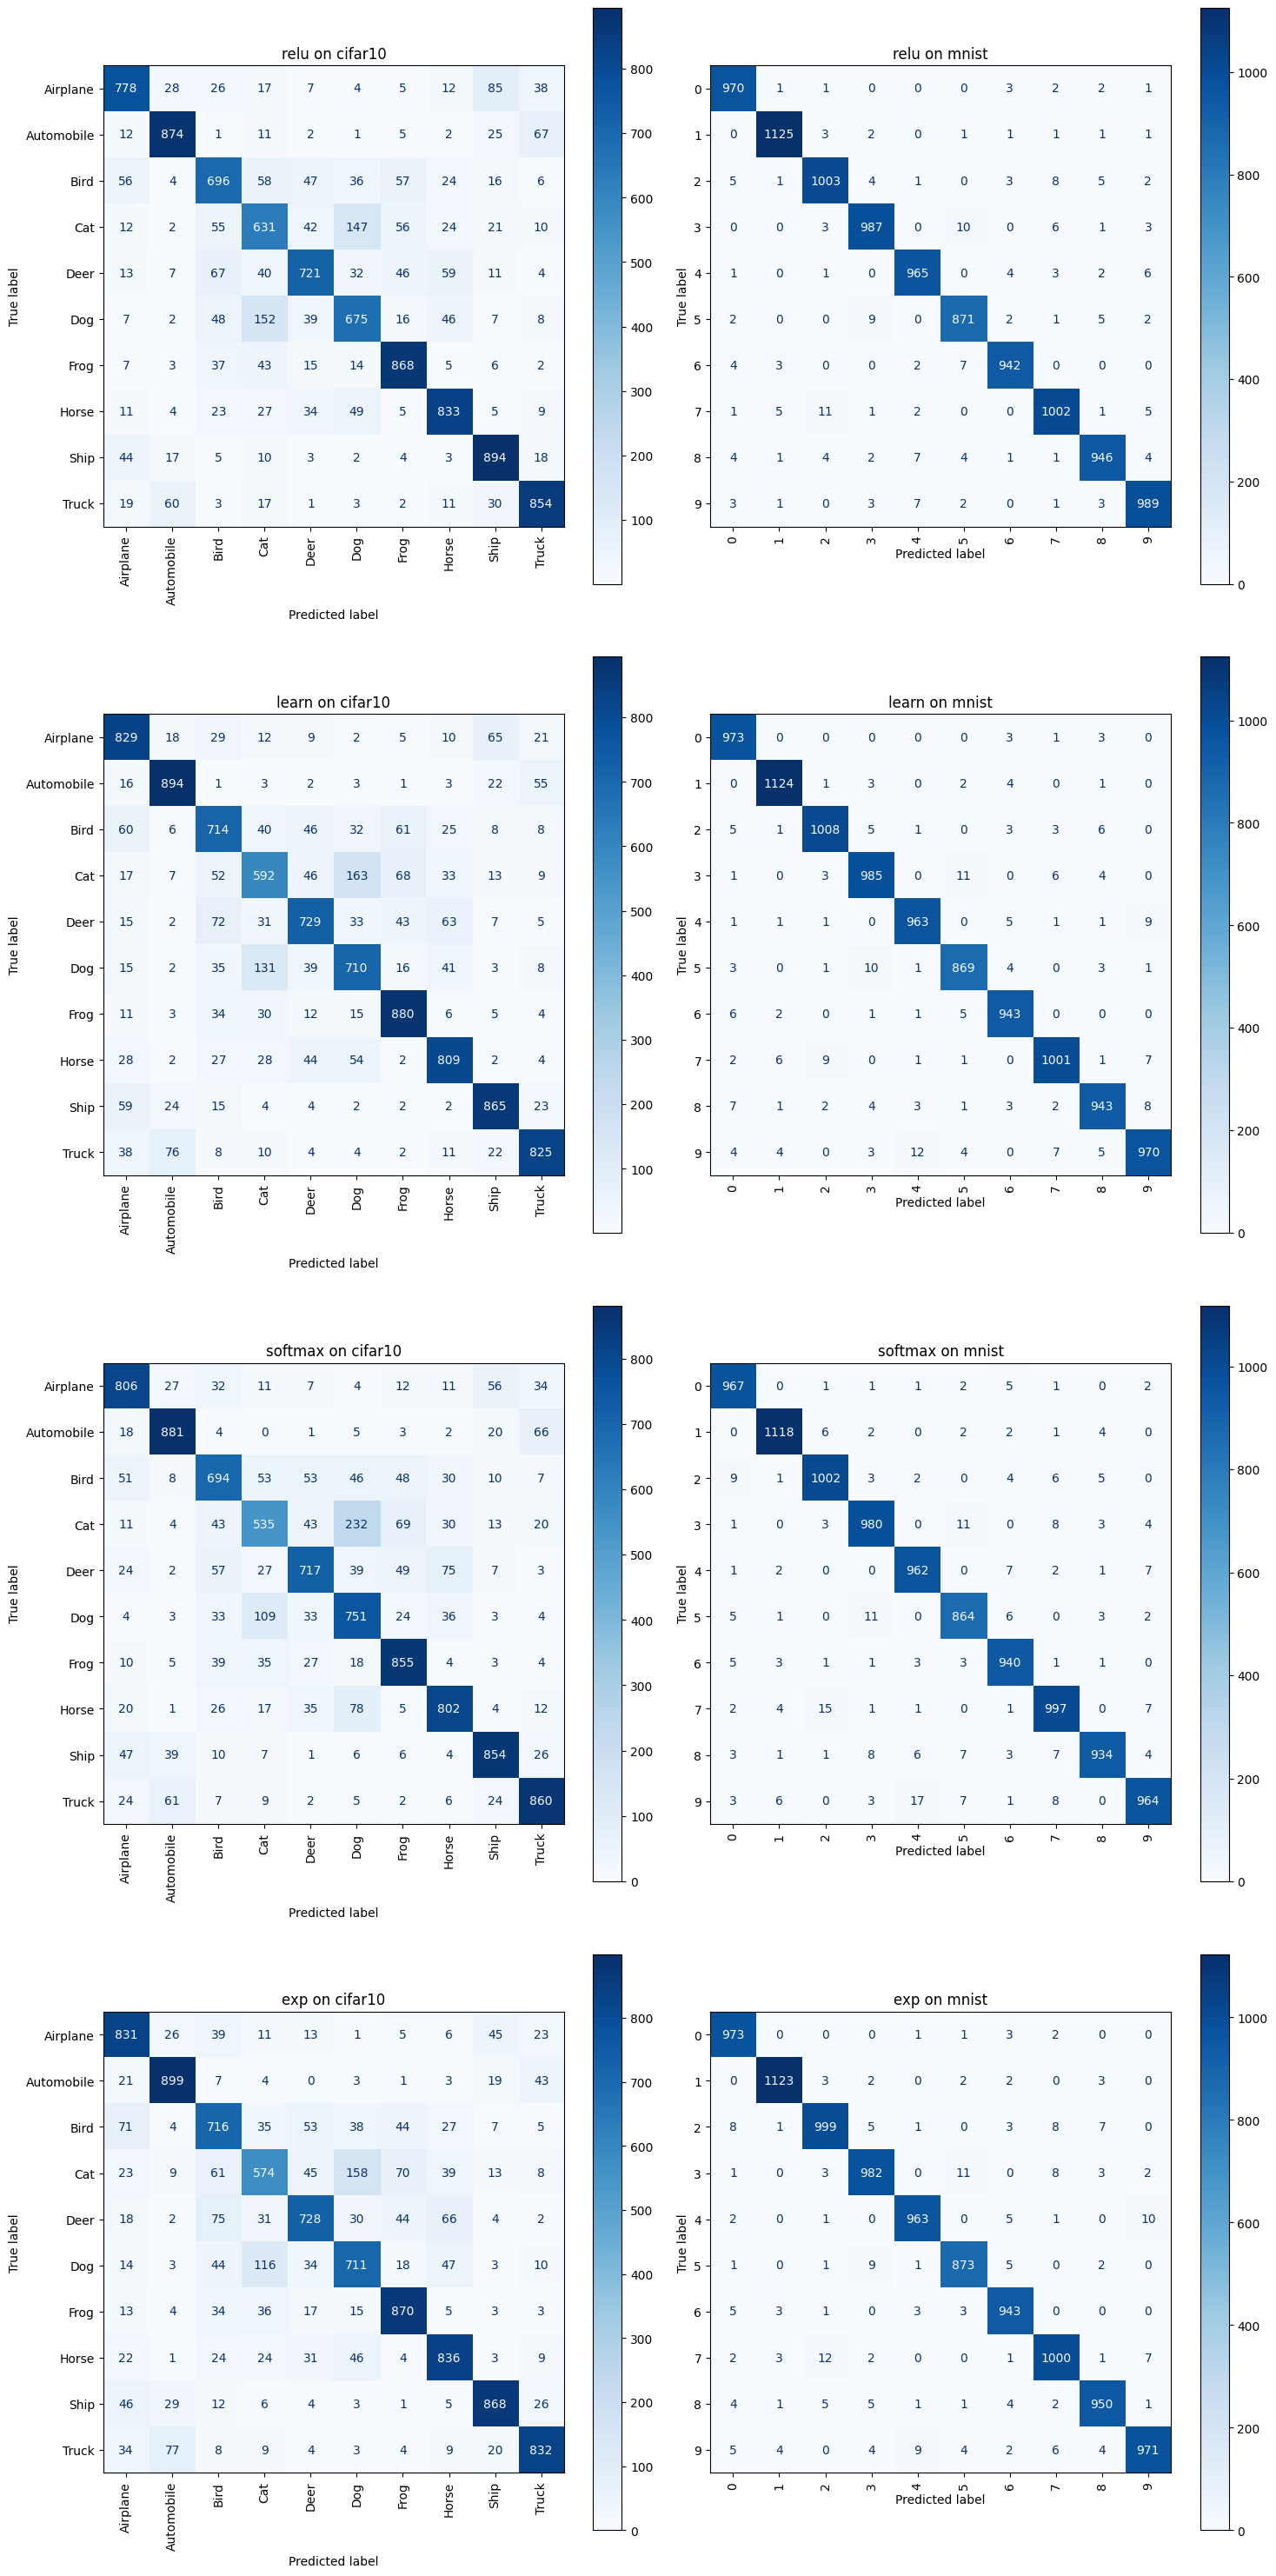

In [9]:
fig = plot_cm(unq_models=unq_models, unq_datasets=unq_datasets, model_data=model_data)
fig

CIFAR10 Specific

In [14]:
def transform(img, channels):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize([0.5]*channels, [0.5]*channels)
    ])
    return transform(img)

images = list()
for img_name in os.listdir(img_dir):
    if not img_name.lower().endswith(('.jpeg', '.jpg')): continue
    img = Image.open(f'{img_dir}/{img_name}').convert('RGB').resize((32, 32))
    images.append(img)

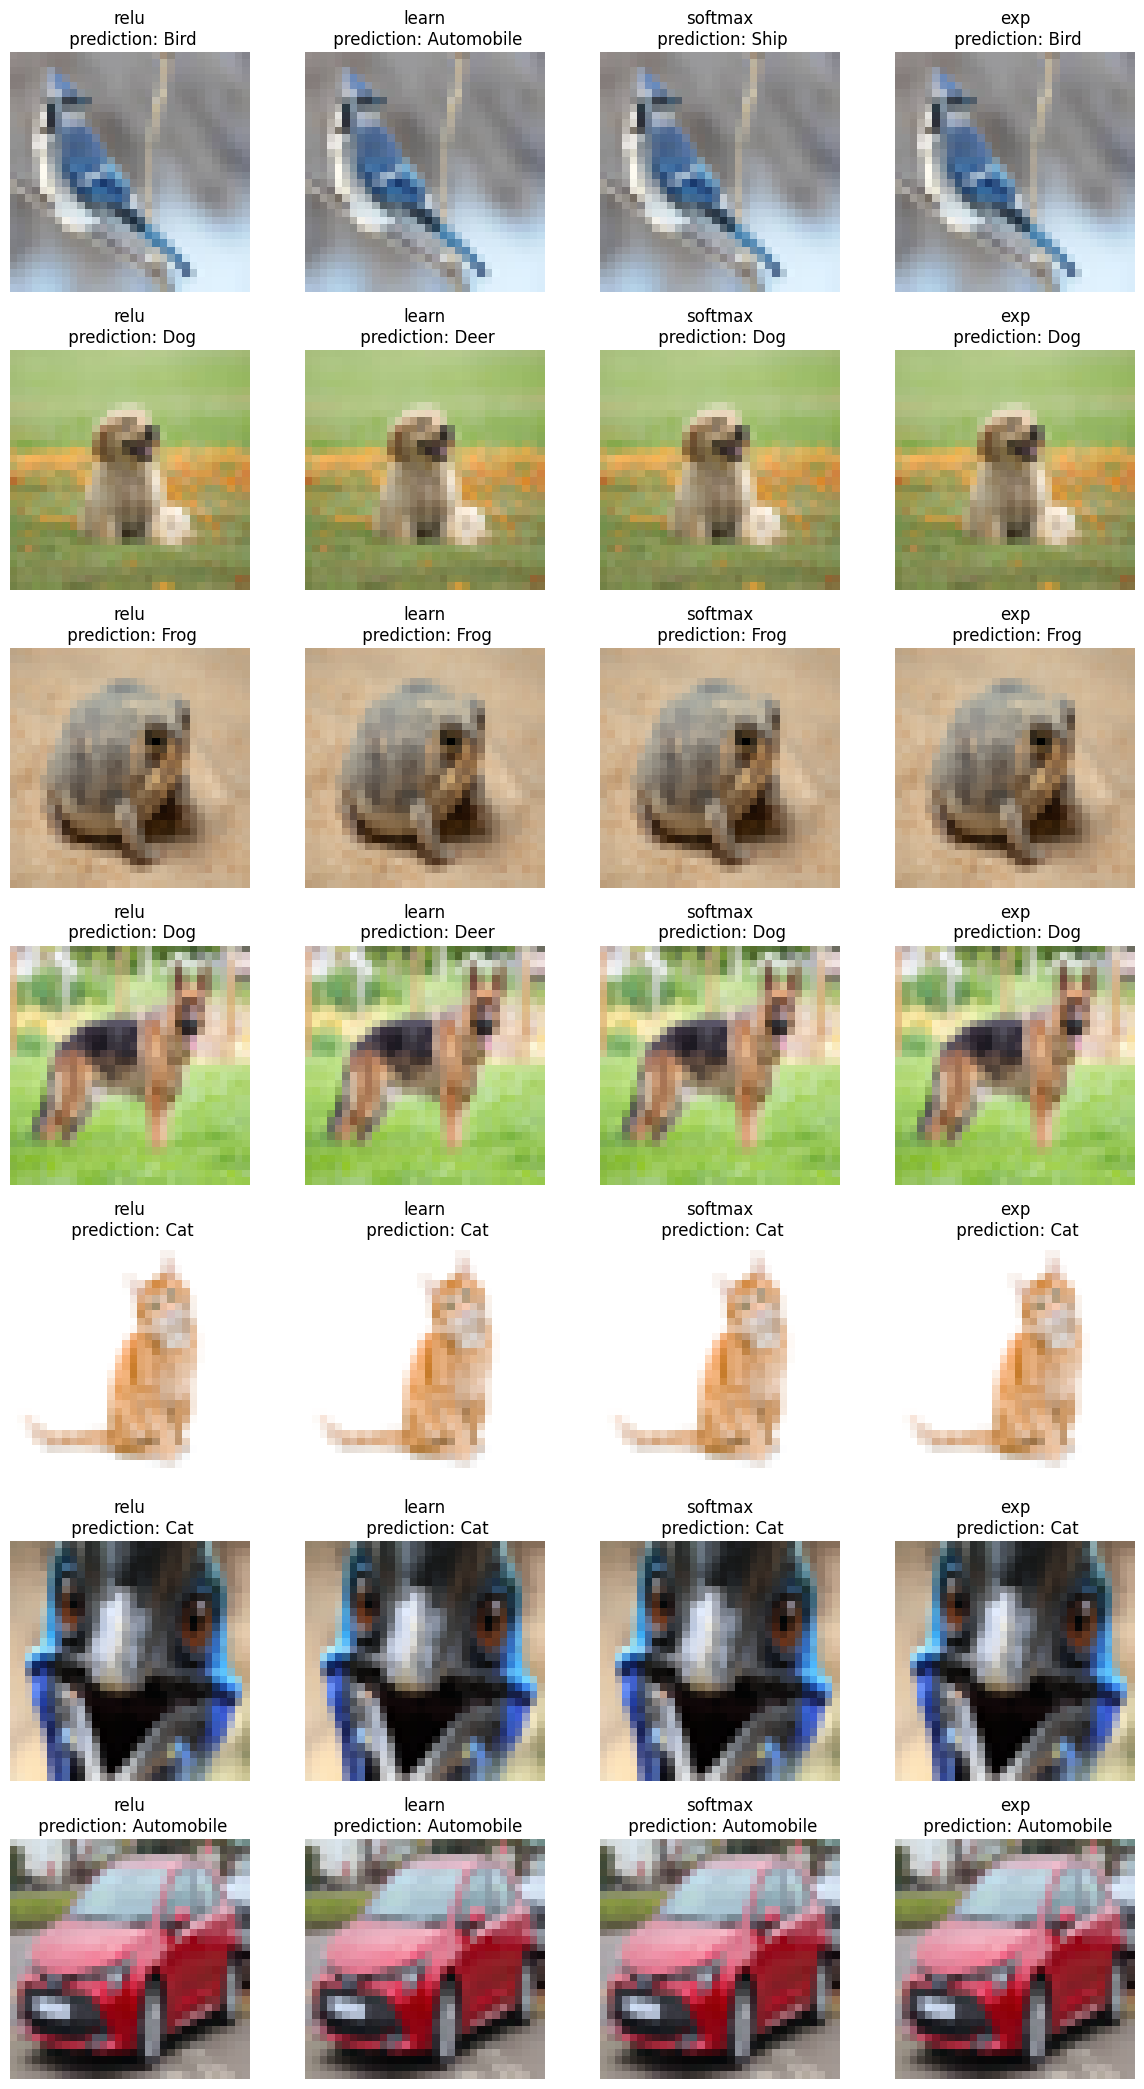

In [15]:
fig, ax = plt.subplots(len(images), len(unq_models), figsize=(12, 21))

for i, img in enumerate(images):
    input_img = transform(img=img, channels=3).unsqueeze(0).to(device)

    for j, model_name in enumerate(unq_models):
        model = model_data['cifar10'][model_name]
        model.eval()
        with torch.no_grad(): output = model(input_img)

        pred = model_data['cifar10']['class_names'][output.argmax(dim=1).item()]

        ax[i, j].imshow(img)
        ax[i, j].set_title(f'{model_name}\n prediction: {pred}')
        ax[i, j].axis('off')

plt.tight_layout()

Sandbox

In [12]:
# unq_models, unq_datasets

In [13]:
# model_data['cifar10'].keys()